October: This notebook extracts the realistic bathymetry of the domain.

In [1]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, Geod, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colormap_ibcao
from scipy.interpolate import griddata
%matplotlib inline

# 1. Get the coordinates of the mackenzie grid

The coordinates in these files are in geographic projection.

In [2]:
coord_name = 'coords_mack06.nc'
grid_name = 'grid_mack06.nc'

In [3]:
# Post JP matlab script
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/' + coord_name)
lon_g_coord = coord_file['nav_lon']
lat_g_coord = coord_file['nav_lat']

# Produced by SEAgrid
grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_grids/' + grid_name)
lon_g_grid = grid_file['grid_lons']
lat_g_grid = grid_file['grid_lats']

# 2. Get the IBCAO coordinates and bathymetry

The coordinates in this file are in stereographic projection, which is used to mitigate the effects of projection distortion in the Arctic.

In [4]:
# Full dataset
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]

In [5]:
# Slice greater canyon region
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

# 3. Convert grid coordinates into stereographic values

In [6]:
# Geographical coordinate system
proj_geogr = Proj("+init=EPSG:4326")
# IBCAO polar stereographic
proj_stere = Proj("+init=EPSG:3996") 

# Using coord file
lon_s_coord =  np.zeros_like(lon_g_coord)
lat_s_coord =  np.zeros_like(lat_g_coord)
for i in np.arange(lon_g_coord.shape[0]):
    lon_s_coord[i,:], lat_s_coord[i,:] = transform(proj_geogr, proj_stere, lon_g_coord[i,:], lat_g_coord[i,:])
    
# Using grid file
lon_s_grid =  np.zeros_like(lon_g_grid)
lat_s_grid =  np.zeros_like(lat_g_grid)
for i in np.arange(lon_g_grid.shape[0]):
    lon_s_grid[i,:], lat_s_grid[i,:] = transform(proj_geogr, proj_stere, lon_g_grid[i,:], lat_g_grid[i,:])

# 4. Extract canyon bathymetry

https://github.com/scipy/scipy/blob/v0.14.0/scipy/interpolate/ndgriddata.py#L81

# A) From JP script

In [7]:
X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_coord, lat_s_coord), method='nearest')

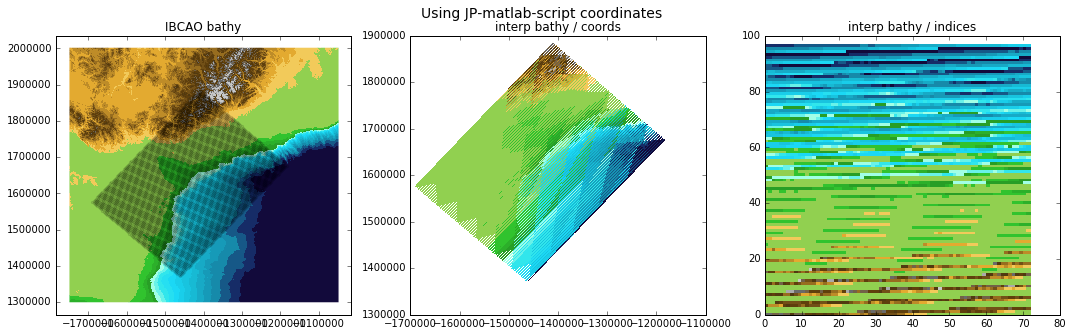

In [8]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
cmap, norm = colormap_ibcao.Colormap()
levels = [-3000, -2000, -1000, 0, 1000, 2000]
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_coord, lat_s_coord, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolor(lon_s_coord, lat_s_coord, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolor(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using JP-matlab-script coordinates', fontsize=14)

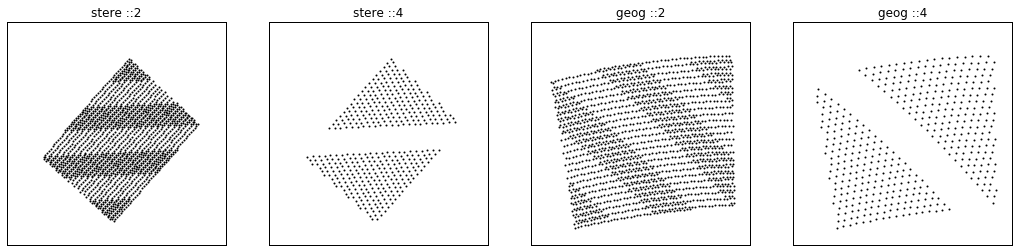

In [9]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
lon_these = [lon_s_coord, lon_s_coord, lon_g_coord, lon_g_coord]
lat_these = [lat_s_coord, lat_s_coord, lat_g_coord, lat_g_coord]
ns = [2, 4, 2, 4]
titles = ['stere', 'stere', 'geog', 'geog']
for lon_this, lat_this, n, i, title in zip (lon_these, lat_these, ns, np.arange(4), titles):
    ax[i].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1)
    ax[i].set_title(title+' ::'+str(n))
    ax[i].xaxis.set_visible(False); ax[i].yaxis.set_visible(False)

# B) From SEAgrid

In [17]:
X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_grid, lat_s_grid), method='nearest')

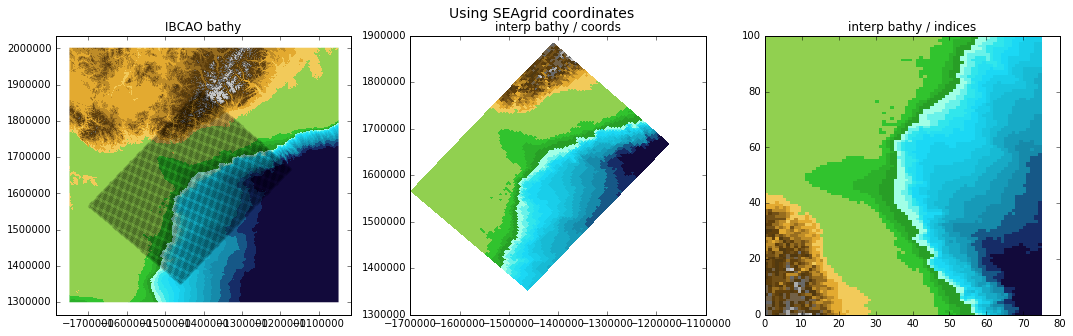

In [11]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_grid, lat_s_grid, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolor(lon_s_grid, lat_s_grid, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolor(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using SEAgrid coordinates', fontsize=14)

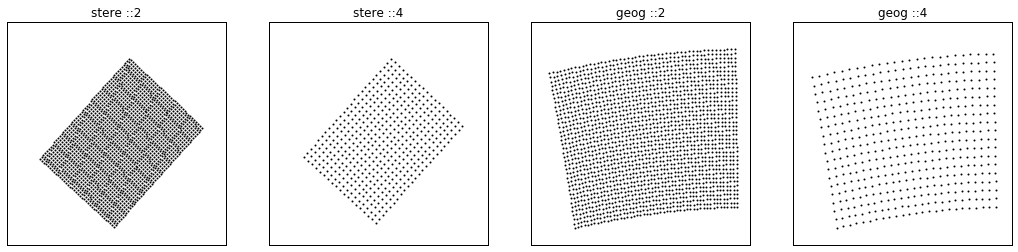

In [12]:
fig, ax = plt.subplots(1,4,figsize=(18,4))
lon_these = [lon_s_grid, lon_s_grid, lon_g_grid, lon_g_grid]
lat_these = [lat_s_grid, lat_s_grid, lat_g_grid, lat_g_grid]
ns = [2, 4, 2, 4]
titles = ['stere', 'stere', 'geog', 'geog']
for lon_this, lat_this, n, i, title in zip (lon_these, lat_these, ns, np.arange(4), titles):
    ax[i].scatter(lon_this[::n,::n], lat_this[::n,::n], s = 1)
    ax[i].set_title(title+' ::'+str(n))
    ax[i].xaxis.set_visible(False); ax[i].yaxis.set_visible(False)

# C) Rotate and Cubic

In [77]:
lon_s_grid_rotate = np.fliplr(np.rot90(lon_s_grid, 3))
lat_s_grid_rotate = np.fliplr(np.rot90(lat_s_grid, 3))
# ----------------------------------

X_region, Y_region = np.meshgrid(x_region, y_region) 
points = np.c_[np.ravel(X_region), np.ravel(Y_region)]
values = np.ravel(z_region)
# ----------------------------------

z_canyon = griddata(points, values, (lon_s_grid_rotate, lat_s_grid_rotate), method='cubic')

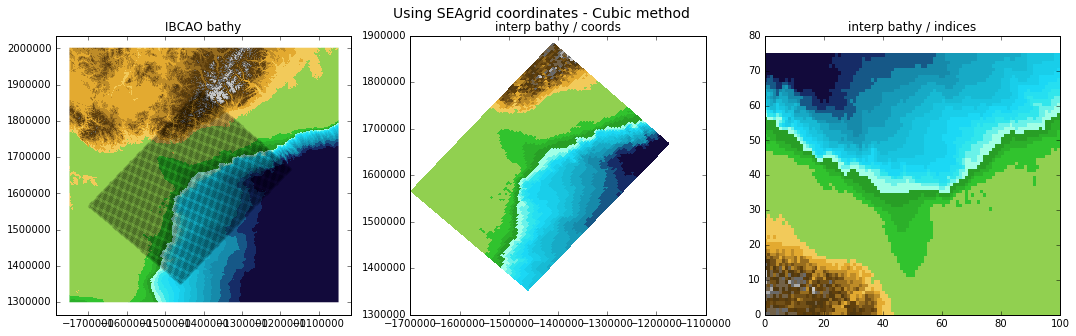

In [86]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[0].scatter(lon_s_grid_rotate, lat_s_grid_rotate, c='k', s=5, alpha=0.1)
ax[0].set_title('IBCAO bathy')
ax[1].pcolormesh(lon_s_grid_rotate, lat_s_grid_rotate, z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[1].set_title('interp bathy / coords')
ax[2].pcolormesh(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax[2].set_title('interp bathy / indices')
fig.suptitle('Using SEAgrid coordinates - Cubic method', fontsize=14)

# 4) Periodic Boundaries

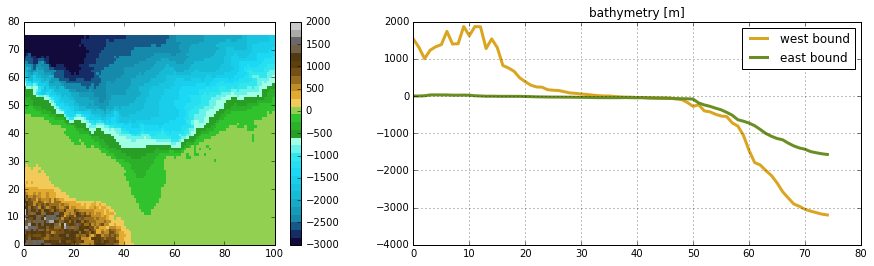

In [367]:
fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[1.4,2]}, figsize=(15,4))
c = axes[0].pcolormesh(z_canyon, vmin = levels[0], vmax = levels[-1], cmap = cmap)
fig.colorbar(c, ax = axes[0])
axes[1].plot(z_canyon[:, 0], lw = 3, c = 'Goldenrod', label = 'west bound')
axes[1].plot(z_canyon[:, -1], lw = 3, c = 'OliveDrab', label = 'east bound')
axes[1].grid(); axes[1].set_title('bathymetry [m]'); axes[1].legend()

In [334]:
x_extended = np.arange(z_canyon.shape[1] + 20)
x_original = np.append(np.arange(z_canyon.shape[1]),x_extended[-1])
y_original = np.arange(z_canyon.shape[0])
z_original = np.concatenate([z_canyon,z_canyon[:,:1]], axis=1)
# ----------------------------------

X_original, Y_original = np.meshgrid(x_original, y_original)
points = np.c_[np.ravel(X_original), np.ravel(Y_original)]
values = np.ravel(z_original)
# ----------------------------------

X_extended, Y_extended = np.meshgrid(x_extended, y_original)
# ----------------------------------

z_extended_cubic = griddata(points, values, (X_extended, Y_extended), method='cubic')
z_extended_linear = griddata(points, values, (X_extended, Y_extended), method='linear')

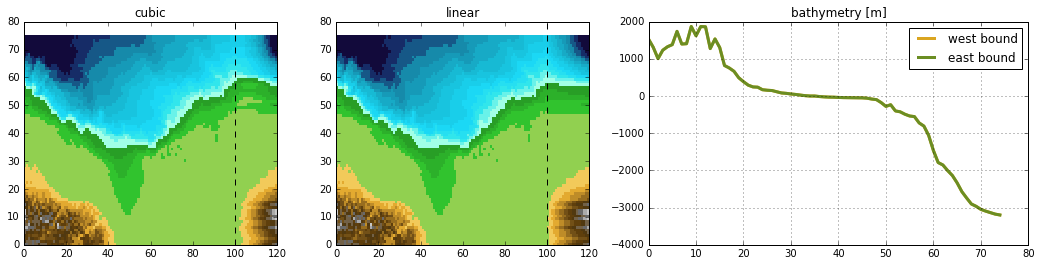

In [366]:
fig, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios':[1,1,1.5]}, figsize=(18,4))
axes[0].pcolormesh(z_extended_cubic, vmin = levels[0], vmax = levels[-1], cmap = cmap); axes[0].set_title('cubic')
axes[1].pcolormesh(z_extended_linear, vmin = levels[0], vmax = levels[-1], cmap = cmap); axes[1].set_title('linear')
axes[0].axvline(z_canyon.shape[1], c='k', linestyle='--')
axes[1].axvline(z_canyon.shape[1], c='k', linestyle='--')
axes[2].plot(z_extended_cubic[:, 0], lw = 3, c = 'Goldenrod', label = 'west bound')
axes[2].plot(z_extended_cubic[:, -1], lw = 3, c = 'OliveDrab', label = 'east bound')
axes[2].grid(); axes[2].set_title('bathymetry [m]'); axes[2].legend()